In [1]:
# !pip3 install --upgrade IPython
# import os
# os._exit(00) # Restarts to lastest versino of IPython.

# **DISABLE `os._exit(00)` TO RUN PAGE.**

In [ ]:
save_collision_data = False 

Set `save_collision_data` to `True` if a local save of the data is wanted to user's google `My Drive`.

In [2]:
import IPython
IPython.__version__

'5.5.0'

This is an assignment for Data Analytics on the Web, a short course with the Univesity of the Highlands and Islands. 

This will look at collision data from New York and attempt to fix some of the missing data. As a pretext, some of the missing `borough` data may be missing for a reason, in that it would not exist, but the data being filled in is purely for the exercise.

The collision data will then be combined with data from the weather station in central park to see if weather may have an adverse affect on driving conditions. The purpose of finding the `borough` is to optimise data by finding any correlation that may bias the data by bad driving in a particular neighborhood.

The Machine Learning models used in this particular assignment will be Linear Regression and Neural Networks. 

# Setting up Google
To begin the data will be taken from Google's data warehouse BigQuery, and that requires the user to be signed in.

In [3]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


### Optional: Google Colab Data Table enable 

Google has an optional `google.colab.data_table` function that can be enabled to view large pandas dataframes as interactive tables.

In [4]:
%load_ext google.colab.data_table

To return to the classic pandas dataframe style then run the next section of code.

In [5]:
# %unload_ext google.colab.data_table

### Setting up BigQuery
Because this assignment will be drawing its data from BigQuery a project name has to be used.

The project name I have used for my assignment is `uhi-project-20023167`.

*Though I am unsure if following users may have to set up their own unique **cloud console project** to run this code.*

In [6]:
project_id = 'uhi-project-20023167'

### Making a query

The `bigquery` function will be imported from `google.cloud`. This is to create a `client` object for which to make a query with. The project id declaired above will be assigned, telling BigQuery what project the query is with.

The query itself is made as a string block with SQL syntax. 

*(This may take a while so feel free to get a cup of tea!)*

In [166]:
import pandas as pd

weather_df = pd.io.gbq.read_gbq('''
  SELECT *
  FROM `uhi-project-20023167.assignment.weather_2012_to_2020`
  ''', project_id=project_id, dialect='standard')

collision_df = pd.io.gbq.read_gbq('''
  SELECT *
  FROM `uhi-project-20023167.assignment.collision_known`
  ''', project_id=project_id, dialect='standard' )

collision_gps_df = pd.io.gbq.read_gbq('''
  SELECT *
  FROM `uhi-project-20023167.assignment.collision_gps_known`
  ''', project_id=project_id, dialect='standard' )

# collision_unknown_df = pd.io.gbq.read_gbq('''
#   SELECT *
#   FROM `uhi-project-20023167.assignment.collision_unknown`
#   ''', project_id=project_id, dialect='standard' )

main_boroughs_count = collision_df['borough'].value_counts() # Gives count of collisions in each boroughs of the main dataset


The data is created using 3 queries:

Query | Specifying Not `Null` Values Selected | Specifying `Null` Values  Selected
---|---|---
`collision_known`| `borough` |  -
`collision_gps_known` | `longitude`, `latitude`, `location`| `borough` 
`collision_unknown` | `cross_street_name`, `on_street_name`, `off_street_name`|`borough`, `longitude`, `latitude`, `location`

The entry `borough` is the detail sought. Some entries have this detail known, which are gathered for the main dataset. Where the `borough` is unknown two methods are proposed for finding it. The first is using GPS data, `longitude` and `latitude`, to put a name to location using addressing data, and the second would be to create a probability of collisions based on the former datasets where a relationship between `borough` and `*_street_name`. Directly relating `*_street_name` to  `borough` may lead to inconsistencies where a street could run through more than one `borough`.

In [8]:
collision_gps_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355918 entries, 0 to 355917
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   borough            0 non-null       object        
 1   timestamp          355918 non-null  datetime64[ns]
 2   latitude           355918 non-null  float64       
 3   longitude          355918 non-null  float64       
 4   location           355918 non-null  object        
 5   cross_street_name  49206 non-null   object        
 6   on_street_name     281010 non-null  object        
 7   off_street_name    13416 non-null   object        
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 21.7+ MB


In [9]:
collision_gps_df.head()

,borough,timestamp,latitude,longitude,location,cross_street_name,on_street_name,off_street_name
0,None,2017-05-19 08:30:00,40.774357,-73.912865,"(40.774357, -73.912865)",None,31 STREET,None
1,None,2017-05-12 20:45:00,40.770770,-73.917270,"(40.77077, -73.91727)",31 STREET,HOYT AVENUE NORTH,None
2,None,2017-05-19 04:30:00,40.734768,-73.861595,"(40.734768, -73.861595)",None,LONG ISLAND EXPRESSWAY,None
3,None,2017-05-12 08:00:00,40.745148,-73.933480,"(40.745148, -73.93348)",VANDAM STREET,QUEENS BOULEVARD,None
4,None,2017-05-15 19:15:00,40.877525,-73.864430,"(40.877525, -73.86443)",None,HOLLAND AVENUE,None


To fill the `borough` column from `collision_gps_*` a python package `uszipcode` is required. This is not naturally available on colab so it must be installed by the cell below.

In [10]:
!pip install uszipcode

     |████████████████████████████████| 378kB 4.3MB/s 
     |████████████████████████████████| 81kB 2.3MB/s 
     |████████████████████████████████| 122kB 21.8MB/s 
     |████████████████████████████████| 51kB 5.5MB/s 
  Created wheel for autopep8: filename=autopep8-1.5.4-py2.py3-none-any.whl size=45287 sha256=7287cf81b876dff174d3826710c6f671f25c6a8bf332a0798f61f6cab80137d2
  Stored in directory: /root/.cache/pip/wheels/b2/31/85/71db2edd0f7b97ad8fd9de009b8ab2e6a98064595d74aff18e
Successfully built autopep8


The SearchEngine object from `uszipcode` is imported and assigned to a variable to be used in a pandas `.apply()` method, which takes the longitude and latitude data, performs a search and returns a list result objects.

The `uszipcode.SearchEngine` allows a search to be performed `by_coordinates`, which takes in a latitude and longitude by `lat` and `lng`, performs a search within a `radius`, in miles, and can return a specified number of results. The results are returns as a list result objects, and the first one is selected with `[0]` which holds the details about that partiuclar 'closest' zip code. From the results, the `major_city` element of the object will largely find the borough but it sometimes finds neighbourhoods of the boroughs. For this lists of the neighbourhoods have been created to filter the result into their appropriate borough. 

The returned `major_city` or filtered `borough` will be in string format, which will be useful for encoding the counts of collisions later.

If no `major_city` objects are returned then the function below returns a `None` with, which will be dropped later using a function as that data will be considered unusuable. (Possibly due to instrumentation error or a response outwith the GPS domain of New York.) 

There may be a better/quicker way to do this.

*(if running, it will take a while. Feel free to fetch that second cup of tea...)*

In [11]:
from uszipcode import SearchEngine
import numpy as np

search = SearchEngine(simple_zipcode=True) # set simple_zipcode=True to not use rich info database

STATEN_ISLE_loc = ["Staten Island", "Annadale", "Arden Heights", "Arlington", "Arrochar", "Bay Terrace", "Bloomfield", 
                   "Brighton Heights", "Bulls Head", "Castleton Corners", "Charleston", "Chelsea", "Clifton", 
                   "Concord", "Dongan Hills", "Egbertville", "Elm Park", "Eltingville", "Emerson Hill", 
                   "Fort Wadsworth", "Graniteville", "Grant City", "Grasmere", "Great Kills", "Greenridge", 
                   "Grymes Hill", "Hamilton Park", "Heartland Village", "Huguenot", "Lighthouse Hill", "Livingston", 
                   "Manor Heights", "Mariners Harbor", "Meiers Corners", "Midland Beach", "New Brighton", "New Dorp",
                   "New Springville", "Oakwood", "Old Place", "Old Town", "Pleasant Plains", "Port Ivory", 
                   "Port Richmond", "Prince's Bay", "Randall Manor", "Richmond Valley", "Richmondtown", "Rosebank", 
                   "Rossville", "Saint George", "Sandy Ground", "Shore Acres", "Silver Lake", "South Beach", "Stapleton", 
                   "Stapleton Heights", "Sunnyside", "Todt Hill", "Tompkinsville", "Tottenville", "Tottenville Beach",
                   "Travis", "Ward Hill", "West New Brighton", "Westerleigh", "Willowbrook", "Woodrow"]
                   
MANHATTAN_loc = ["New York", "Manhattan", "Upper Manhattan", "Marble Hill", "Inwood", "Fort George", 
                 "Washington Heights", "Hudson Heights", "West Harlem", "Hamilton Heights", 
                 "Manhattanville", "Morningside Heights", "Central Harlem", "Harlem", 
                 "St. Nicholas Historic District", "Strivers' Row", "Astor Row", "Sugar Hill", 
                 "Central Harlem", "Marcus Garvey Park, Mount Morris Historical District", 
                 "Le Petit Senegal", "Little Senegal", "East Harlem (Spanish Harlem)", "Upper East Side", 
                 "Lenox Hill", "Carnegie Hill", "Yorkville", "Upper West Side", "Manhattan Valley", 
                 "Bloomingdale District", "Lincoln Square", "San Juan Hill", "Flower District", "Brookdale", 
                 "Hudson Yards", "Kips Bay", "Rose Hill", "NoMad", "Peter Cooper Village", "Gas House district",
                 "Chelsea", "Flatiron District", "Toy District", "Photo District", "Gramercy Park", 
                 "Stuyvesant Square", "Union Square", "Stuyvesant Town", "Meatpacking District", 
                 "Waterside Plaza", "Downtown Manhattan", "Little Germany", "Alphabet City and Loisaida",
                 "East Village", "Greenwich Village", "NoHo", "Bowery", "West Village", "Lower East Side",
                 "SoHo", "Nolita", "NoLIta", "Little Australia", "Little Italy", "Chinatown", "Financial District",
                 "Five Points", "Cooperative Village†", "Two Bridges", "Tribeca", "TriBeCa", "Civic Center", 
                 "Radio Row", "South Street Seaport Historical District", "Battery Park City", "Little Syria"]

BRONX_loc = ["Bronx", "Northwest Bronx", "Bedford Park", "Belmont (Arthur Avenue)", "Belmont", "Arthur Avenue", 
             "Fordham", "Fordham Heights", "Fordham Manor", "Jerome Park", "Kingsbridge", "Kingsbridge Heights", 
             "Van Cortlandt Village", "Marble Hill", "Norwood", "Riverdale", "Central Riverdale", "Fieldston", 
             "Hudson Hill", "North Riverdale", "Spuyten Duyvil (South Riverdale)", "University Heights", 
             "Woodlawn Heights (North of Woodlawn Cemetery)", "Woodlawn Heights", "Southwest Bronx", "Bathgate", 
             "Claremont", "Concourse", "East Tremont", "Highbridge", "Hunts Point", "Longwood", "Foxhurst", 
             "Woodstock", "Melrose", "Morris Heights", "Morrisania", "Crotona Park East", "Mott Haven", 
             "Port Morris", "The Hub", "Tremont", "Fairmount", "Mount Eden", "Mount Hope", "West Farms", 
             "East Bronx", "Northeast Bronx", "Allerton", "Bronxwood", "Laconia", "Baychester", "Bronxdale", 
             "City Island", "Co-op City", "Eastchester", "Edenwald", "Pelham", "Pelham Gardens", "Pelham Parkway", 
             "Wakefield", "Washingtonville", "Williamsbridge", "Olinville", "Southeast Bronx", 
             "Bronx River (on the border of East and West)", "Bronx River", "Bruckner", "Clason Point", 
             "Country Club", "Harding Park", "Morris Park", "Indian Villag", "Parkchester", "Park Versailles", 
             "Pelham Bay", "Soundview", "Schuylerville", "Throggs Neck (also spelled Throgs Neck)", 
             "Throggs Neck", "Throgs Neck", "Edgewater Park", "Unionport", "Castle Hill", "Van Nest", 
             "Westchester Heights", "Westchester Square", "The Pelham Islands", "The Blauzes", 
             "Chimney Sweeps Islands", "City Island", "Hart Island", "High Island", "Hunter Island", 
             "Rat Island", "Twin Island", "North Brother Island", "South Brother Island", "Rikers Island"]

QUEENS_loc = ['Queens', 'Astoria', 'Astoria Heights', 'Ditmars', 'Steinway', 'Little Egypt', 'Jackson Heights', 
              'Long Island City', 'Blissville', 'Hunters Point', 'Dutch Kills', 
              'Queensbridge', 'Queensbridge (housing development)', 'Queensview', 'Queensview (housing development)', 
              'Queens West', 'Ravenswood', 'Ravenswood (housing development)', 'Sunnyside', 'Sunnyside Gardens', 
              'Northeastern Queens', 'Bayside', 'Bay Terrace', 'Bayside Hills', 'Fort Totten', 
              'Oakland Gardens', 'Bellerose', 'College Point', 'Douglaston–Little Neck', 'Douglaston', 
              'Douglas Bay', 'Douglas Manor', 'Douglaston Hill', 'Douglaston Park', 'Winchester Estates', 
              'Little Neck', 'Pines', 'Little Neck Hills', 'Westmoreland', 'Flushing', 'Auburndale', 
              'Broadway-Flushing', 'Bowne Park', 'Chinatown', 'Downtown Flushing', 'Kew Gardens Hills', 
              'Koreatown', 'Linden Hill', 'Murray Hill', 'Willets Point', 'Pomonok', 'Electchester', 
              'Queensboro Hill', 'Floral Park', 'Fresh Meadows', 'Hillcrest', 'Utopia', 'Glen Oaks', 
              'North Shore Towers', 'North Shore Towers (housing development)', 'Whitestone', 'Beechhurst', 
              'Clearview', 'Malba', 'Central Queens', 'Briarwood', 'Corona', 'LeFrak City', 
              'LeFrak City (housing development)', 'North Corona', 'East Elmhurst', 'Elmhurst', 
              'Forest Hills', 'Forest Hills Gardens', 'Fresh Pond', 'Glendale',
              'Jackson Heights', 'Kew Gardens', 'Maspeth', 'Middle Village', 'Rego Park', 'Ridgewood', 
              'Wyckoff Heights', 'Woodside', 'Southeastern Queens', 'Bellaire', 'Brookville', 
              'Cambria Heights', 'Hollis Hills', 'Hollis', 'Holliswood', 'Jamaica', 'Jamaica Estates', 
              'Jamaica Hills', 'Laurelton', 'Meadowmere', 'Queens Village', 'Rochdale Village', 
              'Rochdale Village (Cooperative Housing Development)', 'Rosedale', 'Saint Albans', 
              'South Jamaica', 'Springfield Gardens', 'Warnerville', 'Southwestern Queens', 
              'The Hole', 'Howard Beach', 'Hamilton Beach', 'Howard Park', 
              'Lindenwood ', 'Lindenwood (housing development)', 'Old Howard Beach', 'Ramblersville', 
              'Rockwood Park', 'Ozone Park', 'South Ozone Park', 'Tudor Village', 'Richmond Hill',
              'South Richmond Hill', 'Elmont', 'Valley Stream', 
              'Woodhaven', 'The Rockaways', 'Main article: Rockaway, Queens', 'Arverne', 'Bayswater', 
              'Belle Harbor', 'Breezy Point', 'Broad Channel', 'Edgemere', 'Far Rockaway', 'Hammels', 
              'Neponsit', 'Rockaway Beach', 'Rockaway Park', 'Roxbury', 'Seaside']

BROOKLYN_loc = ["Brooklyn", "Central Brooklyn", "Crown Heights", "Weeksville", "Flatbush", "Beverley Squares ", 
                "Beverley Square East ", "Beverley Square West", "Ditmas Park", "East Flatbush", "Farragut", 
                "Remsen Village", "Fiske Terrace", "Pigtown", "Wingate", "Prospect Park area", 
                "Prospect Lefferts Gardens", "Prospect Park South", "Windsor Terrace[1]", "Windsor Terrace", "Kensington", 
                "Ocean Parkway", "Parkville", "Eastern Brooklyn", "Brownsville", "Canarsie", 
                "East New York", "City Line", "Cypress Hills", "New Lots", "Spring Creek", "Starrett City", 
                "Highland Park", "Northern Brooklyn", "Bedford–Stuyvesant[2]", "Bedford–Stuyvesant", 
                "Bedford", "Ocean Hill", "Stuyvesant Heights", "Bushwick", "Wyckoff Heights", 
                "East Williamsburg", "Greenpoint", "Little Poland", "Williamsburg", "Northwestern Brooklyn", 
                "Brooklyn Heights", "Brooklyn Navy Yard", "Admiral's Row", "Cadman Plaza", "Clinton Hill", 
                "Downtown Brooklyn", "Bridge Plaza/RAMBO", "DUMBO", "Fulton Ferry", "Fort Greene", 
                "Prospect Heights", "Pacific Park/Atlantic Yards", "Vinegar Hill", "South Brooklyn", 
                "Boerum Hill", "Carroll Gardens", "Columbia Street Waterfront District", "Cobble Hill", 
                "Gowanus", "Park Slope", "South Park Slope", "Greenwood Heights", "Red Hook", 
                "Southern Brooklyn", "Barren Island", "Bergen Beach and Georgetown", "Bergen Beach", 
                "Georgetown", "Coney Island", "Brighton Beach", "Little Odessa", "West Brighton", 
                "Manhattan Beach", "Sea Gate", "Sheepshead Bay and Madison", "Madison", "Sheepshead Bay", 
                "Homecrest", "Midwood", "Flatlands", "Gerritsen Beach", "Gravesend", "White Sands", 
                "Marine Park", "Mill Basin", "Plumb Beach", "Bay Ridge", "Fort Hamilton", "Bensonhurst", 
                "Bath Beach", "New Utrecht", "Borough Park", "Mapleton ", "Bensonhurst", "Dyker Heights", 
                "Sunset Park", "Chinatown", "Sunset Industrial Park", "Bushwick", "Bushwick", "Greenpoint",
                "Williamsburg", "Brooklyn", "Bedford-Stuyvesant", "Boerum Hill", "Carroll Gardens", 
                "Cobble Hill", "Brooklyn Heights", "Brownsville", "City Line", "Clinton Hill", 
                "Crown Heights", "Cypress Hills", "Downtown Brooklyn", "DUMBO", "East New York", 
                "Fort Greene", "Gowanus", "Greenwood Heights", "Highland Park", "New Lots", "Ocean Hill",
                "Park Slope", "Prospect Heights", "RAMBO", "Spring Creek", "Starrett City", 
                "Stuyvesant Heights", "Sunset Park", "Vinegar Hill", "Weeksville", "Windsor Terrace",
                "Wingate", "Flatlands", "Bergen Beach", "Canarsie", "Flatlands", "Georgetown", 
                "Marine Park", "Mill Basin", "The southeastern quarter of Midwood", "Gravesend",
                "Brighton Beach", "Coney Island", "Gerritsen Beach", "Gravesend", "Homecrest", 
                "Madison", "Midwood", "Manhattan Beach", "Plum Beach", "Seagate", "Sheepshead Bay",
                "New Utrecht", "Bay Ridge", "Borough Park", "Dyker Heights", "Mapleton", "New Utrecht",
                "Bath Beach", "Bensonhurst", "Flatbush", "Ditmas Park", "East Flatbush", "Farragut",
                "Fiske Terrace", "Flatbush", "Kensington", "Prospect Lefferts Gardens", "Prospect Park South"]

def get_zip_code(lat, long):
  print(search.by_coordinates(lat=lat, lng=long, radius=5, returns=5))
  try:
    zip_result = search.by_coordinates(lat=lat, lng=long, radius=5, returns=1)[0]
    return zip_result.zipcode
  except: 
    return None

def gps_get_borough(lat, long, make_print=False):
  if make_print:
    print(search.by_coordinates(lat=lat, lng=long, radius=5, returns=5))
    print(search.by_coordinates(lat=lat, lng=long, radius=5, returns=1)[0].county)
  
  try:
    borough_result = search.by_coordinates(lat=lat, lng=long, radius=5, returns=1)[0].major_city
    if borough_result in STATEN_ISLE_loc:
      return 'STATEN ISLAND'
    elif borough_result in BRONX_loc:
      return 'BRONX'
    elif borough_result in MANHATTAN_loc:
      return 'MANHATTAN'
    elif borough_result in QUEENS_loc:
      return 'QUEENS'
    elif borough_result in BROOKLYN_loc:
      return 'BROOKLYN'
    elif borough_result:
      return borough_result.upper()
    else:
      return np.nan
  
  except:
    return np.nan

collision_gps_df['borough'] = collision_gps_df.apply(lambda x: gps_get_borough(lat=x['latitude'], long=x['longitude']), axis=1) # Finds boroughs by using GPS coordinates

# collision_gps_df['borough_test_col'] = collision_gps_df.head(10).apply(lambda x: gps_get_borough(lat=x['latitude'], long=x['longitude']), axis=1) # Finds boroughs using GPS coordinates for only the first 10 values. Used for testing.
# ind_x = 3
# gps_get_borough(collision_gps_df['latitude'][ind_x], collision_gps_df['longitude'][ind_x], make_print=True) # Prints the result for an entry on row 'ind_x' from USZipCode package.


Start downloading data for simple zipcode database, total size 9MB ...
  1 MB finished ...
  2 MB finished ...
  3 MB finished ...
  4 MB finished ...
  5 MB finished ...
  6 MB finished ...
  7 MB finished ...
  8 MB finished ...
  9 MB finished ...
  10 MB finished ...
  Complete!


In [12]:
collision_gps_df.head()

,borough,timestamp,latitude,longitude,location,cross_street_name,on_street_name,off_street_name
0,QUEENS,2017-05-19 08:30:00,40.774357,-73.912865,"(40.774357, -73.912865)",None,31 STREET,None
1,QUEENS,2017-05-12 20:45:00,40.770770,-73.917270,"(40.77077, -73.91727)",31 STREET,HOYT AVENUE NORTH,None
2,QUEENS,2017-05-19 04:30:00,40.734768,-73.861595,"(40.734768, -73.861595)",None,LONG ISLAND EXPRESSWAY,None
3,QUEENS,2017-05-12 08:00:00,40.745148,-73.933480,"(40.745148, -73.93348)",VANDAM STREET,QUEENS BOULEVARD,None
4,BRONX,2017-05-15 19:15:00,40.877525,-73.864430,"(40.877525, -73.86443)",None,HOLLAND AVENUE,None


In [13]:
borough_counts = collision_gps_df['borough'].value_counts()
collision_threshold = 1000

print(f"""From the GPS data set:
Number of 'borough' entries filled: {sum(borough_counts)} / {len(collision_gps_df)} = {round(sum(borough_counts) / len(collision_gps_df), 3) * 100}%

Total number of boroughs: {len(borough_counts)}
Number of boroughs with more than {collision_threshold} collisions: {len(borough_counts[borough_counts > collision_threshold])} / {len(borough_counts)} = {round(len(borough_counts[borough_counts > collision_threshold]) / len(borough_counts) * 100, 3)}%
Entries lost by dropping boroughs with less than {collision_threshold} collisions: {sum(borough_counts[borough_counts < collision_threshold])} / {sum(borough_counts)} = {round(sum(borough_counts[borough_counts < collision_threshold])/sum(borough_counts) * 100, 3)}%

Percentage of collisions dropped where boroughs could not be found: {round(sum(collision_gps_df[collision_gps_df['borough'].isna()]['location'].value_counts())/sum(borough_counts) * 100, 5)}%

GPS coordinates where a borough could not be found: 
{collision_gps_df[collision_gps_df['borough'].isna()]['location'].value_counts()}""")

From the GPS data set:
Number of 'borough' entries filled: 355497 / 355918 = 99.9%

Total number of boroughs: 27
Number of boroughs with more than 1000 collisions: 5 / 27 = 18.519%
Entries lost by dropping boroughs with less than 1000 collisions: 130 / 355497 = 0.037%

Percentage of collisions dropped where boroughs could not be found: 0.11843%

GPS coordinates where a borough could not be found: 
(0.0, 0.0)                 296
(40.75837, -201.23706)     105
(40.665226, -32.768513)     16
(40.556175, -47.209625)      3
(40.854286, -201.35999)      1
Name: location, dtype: int64


The number of empty entries in boroughs filled is 99.9%. 27 unique values were found for boroughs, neighbourhoods outwith the scope of the regions being analysed, some of the neighbourhoods with low collisions are from New Jersey.

By creating a threshold of collision counts, 22 boroughs can be omitted as being superfluous simplifying the number of variables in the dataset down to one fifth of the boroughs to process. By dropping these neighborhoods 130 entries from the dataset 0.037% of the data will be lost.

Locations where GPS coordinates could not find a neighbourhood or borough account for 0.118% of results. Printing `value_counts()` of the `location` where `boroughs` were of `NoneType` shows that the values would either be due to instrumentation error or an incorrect value when the data was entered.

Dropping both the values outwith the scope and values appearing in error will account for a loss of less than 0.2% of the GPS converted data. 

The collision counts for each borough and neighborhood is shown as: 

In [14]:
borough_counts

QUEENS              119119
BROOKLYN             87916
MANHATTAN            67343
BRONX                52963
STATEN ISLAND        28026
FORT LEE                36
CEDARHURST              36
YONKERS                 14
ATLANTIC BEACH           9
NESHANIC STATION         7
SEWAREN                  5
MOUNT VERNON             4
ARMONK                   4
BLAUVELT                 2
NEW HYDE PARK            1
VESTAL                   1
ANGOLA                   1
CORRY                    1
GARRISON                 1
MC HENRY                 1
NEW ROCHELLE             1
CARTERET                 1
ATHENS                   1
TOMKINS COVE             1
CENTRAL SQUARE           1
GREAT NECK               1
BAYONNE                  1
Name: borough, dtype: int64

The index values from the `value_count()` of `collision_df` can be used to filter the preferential values from the GPS obtained boroughs. The original values and the salvaged boroughs can then be appended together which will provide more details for when it comes to setting the parameters of the machine learning model.  

In [15]:
print(f"""
The dataset count of collisions complete with boroughs is:
{main_boroughs_count}

The count of collisions added to the dataset from finding the borough from the GPS coordinates are: 
{borough_counts[borough_counts.index.isin(main_boroughs_count.index)]}
""")


The dataset count of collisions complete with boroughs is:
BROOKLYN         376096
QUEENS           321840
MANHATTAN        281839
BRONX            171757
STATEN ISLAND     51019
Name: borough, dtype: int64

The count of collisions added to the dataset from finding the borough from the GPS coordinates are: 
QUEENS           119119
BROOKLYN          87916
MANHATTAN         67343
BRONX             52963
STATEN ISLAND     28026
Name: borough, dtype: int64



In [16]:
collision_df2 = collision_df.append(collision_gps_df[collision_gps_df['borough'].isin(main_boroughs_count.index)], ignore_index=True)
print(f"""
New Complete Collision dataset borough `value_counts()` with additional GPS entries: 
{collision_df2['borough'].value_counts()}
""")


New Complete Collision dataset borough `value_counts()` with additional GPS entries: 
BROOKLYN         464012
QUEENS           440959
MANHATTAN        349182
BRONX            224720
STATEN ISLAND     79045
Name: borough, dtype: int64



A new date column is created so the dataset can be grouped by `date` without time of day being a factor. From that the data will be grouped by `date` and then a `value_counts()` using `borough` will return a count of collisions per day for each borough.

This returned value will be a `MultiIndex` type which combines both the date and the borough in the index. To solve this the `unstack()` function is used. Unstack can break down the data and will name each column after the date, and each row will keep an index value of borough at `level=0`. This easily solved by unstacking at `level=-1` to make the column heads the borough and the row indices of the date value. And each entry under the `borough` column header will hold the number of collisions for that `date` in that `borough`.

The data is now ready to merge with the weather data on the `date` column.

In [17]:
collision_df2['date'] = collision_df2.apply(lambda x: pd.to_datetime(x['timestamp'].date()), axis=1)
collision_df2.head()

,borough,timestamp,latitude,longitude,location,cross_street_name,on_street_name,off_street_name,date
0,BRONX,2017-05-21 10:00:00,40.809105,-73.922900,"(40.809105, -73.9229)",EAST 138 STREET,WILLIS AVENUE,None,2017-05-21
1,MANHATTAN,2017-05-14 19:13:00,40.720320,-73.994040,"(40.72032, -73.99404)",DELANCEY STREET,BOWERY,None,2017-05-14
2,QUEENS,2017-05-20 05:40:00,40.767326,-73.929860,"(40.767326, -73.92986)",31 AVENUE,21 STREET,None,2017-05-20
3,BRONX,2017-05-15 17:07:00,NaN,NaN,None,TRIBOROUGH BRIDGE,BRUCKNER EXPRESSWAY,None,2017-05-15
4,QUEENS,2017-06-04 13:30:00,40.667564,-73.815025,"(40.667564, -73.815025)",149 AVENUE,125 STREET,None,2017-06-04


In [113]:
collision_df3 = collision_df2.groupby('date')['borough'].value_counts().unstack(level=-1)
collision_df3.fillna(np.nan)

borough,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
date,,,,,
2012-07-01,43,140,122,117,31
2012-07-02,72,146,122,107,30
2012-07-03,75,176,155,154,23
2012-07-04,53,104,71,108,25
2012-07-05,62,158,114,141,28
...,...,...,...,...,...
2020-11-19,54,73,34,69,6
2020-11-20,46,107,45,88,10
2020-11-21,61,74,41,70,9


Now the data is complete it can be combined to the weather data by date.

The columns in the weather data are:

Column name | Meaning | Missing Value
---|---|---
`year`, `mo`, and `da`| Year, Month, and day | -
`temp` |Mean Temperature in fahrenheit | `9999.9`
`dewp` |Mean Dew Point in fahrenheit | `9999.9`
`slp` |Sea Level Pressure in millibars  | `9999.9`
`visib` |Mean Visibility in Miles  | `999.9`
`wdsp` |Mean Wind Speed in knots  | `999.9`
`mxpsd` |Maximum sustained Wind Speed in knots  | `999.9`
`gust` |Maximum Wind Gust in knots  | `999.9`
`max` |Maximum Temperature in Fahrenheit | `9999.9`
`min` |Minimum Temperature in Fahrenheit | `9999.9`
`prcp` |Total Precipitation in inches | `99.99`
`sndp` |Snow depth in inches | `999.9`
`fog` |Yes = 1, No = 1 | -

In [30]:
weather_df.head()

,date,year,mo,da,temp,dewp,slp,visib,wdsp,mxpsd,gust,max,min,prcp,sndp,fog
0,2012-01-01,2012,01,01,46.6,38.2,1015.2,10.0,5.2,13.0,17.1,51.1,35.6,0.01,NaN,0
1,2012-01-02,2012,01,02,42.1,25.6,1006.7,9.8,8.9,18.1,22.9,51.1,36.0,0.05,NaN,0
2,2012-01-03,2012,01,03,28.5,12.4,1011.7,10.0,8.8,15.0,24.1,39.9,21.9,0.00,NaN,0
3,2012-01-04,2012,01,04,18.4,1.1,1020.4,10.0,7.2,22.0,NaN,27.0,12.9,0.00,NaN,0
4,2012-01-05,2012,01,05,31.6,15.4,1013.2,10.0,5.8,13.0,18.1,39.9,27.0,0.00,NaN,0


The non-date data imported is set as a float with `astype(float)`. This is to make sure that the data is numerical and not character or object.

The recorded values are cleaned for the unavailable data and replaced with an `np.nan` value from the Numpy library. This is because some mathematical functions don't work properly with Python's standard `NoneType`. 

In [167]:
weather_df.loc[:, 'year':'fog'] = weather_df.loc[:, 'year':'fog'].astype(float)
weather_df = weather_df.replace(9999.9, np.nan)
weather_df[['visib', 'wdsp', 'mxpsd', 'gust', 'sndp']] = weather_df[['visib', 'wdsp', 'mxpsd', 'gust', 'sndp']].astype(float).replace(999.9, np.nan)
weather_df['prcp'] = weather_df['prcp'].replace(99.99, np.nan)

Seaborn is a plotting package for python to be used with pyplot. An example is shown below.

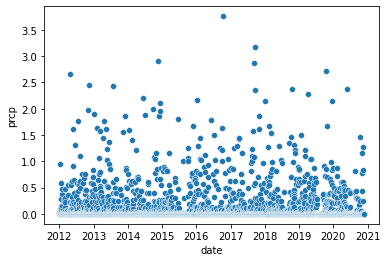

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.scatterplot(x=weather_df['date'], y=weather_df['prcp'])

The weather data starts in the first of January, 2012, but the collision data starts in the first of July, 2012. So the rows with `None` in collision count columns are dropped from the dataset, trimming the weather data.

The length of the dataset remains the same as `collision_df3`.

In [190]:
complete_df = pd.merge(weather_df, collision_df3, how="left", on=["date"])
complete_df = complete_df.dropna(subset=main_boroughs_count.index)
complete_df.set_index('date', inplace = True)
complete_df = complete_df.astype(float)

Using seaborn, a range of scatter/histogram plots can be made where the density of the scatter is shown by the shade of the plot. The more dense the scatter the darker the plot.

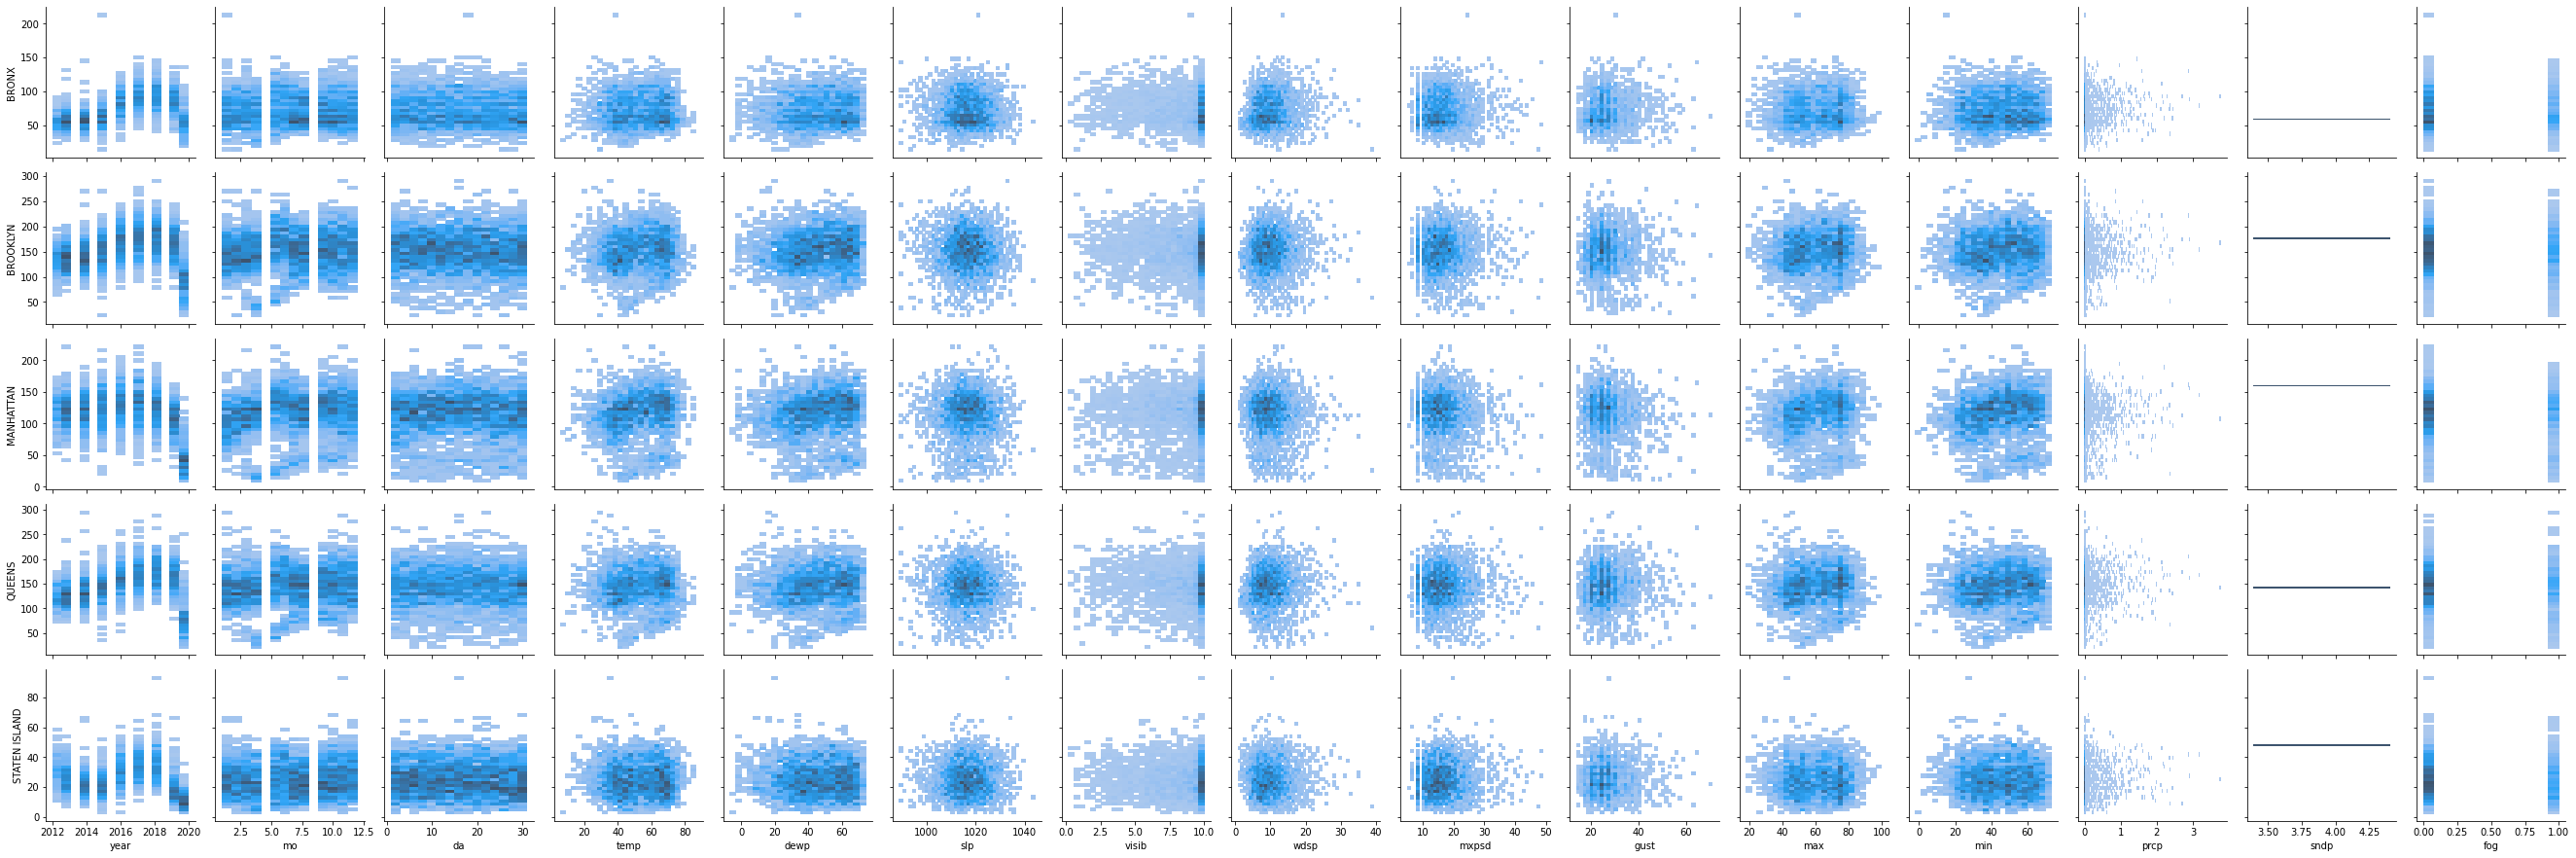

In [169]:
g= sns.PairGrid(complete_df,
             x_vars = complete_df.columns[:-5],
             y_vars = complete_df.columns[-5:],
             )
g.map(sns.histplot)

A correlation plot shows how well  the collisions in the `boroughs` compare with the weather conditions.

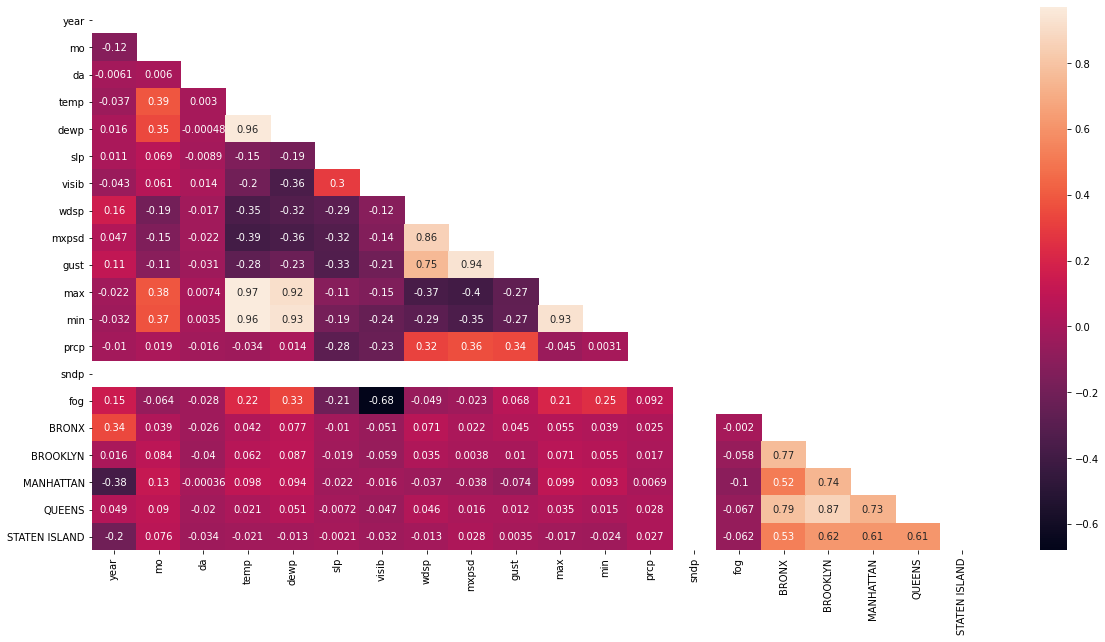

In [171]:
matrix = np.triu(complete_df.corr())
fig, ax = plt.subplots(figsize=(20,10)) 
sns.heatmap(complete_df.corr(), mask=matrix, annot=True)

The Kernel Density Estimate (KDE) plot is similar to the histogram/scatter plot above, taking a bit longer to calculate but it's good at showing the trends of the data by giving contours to show where the most densly populated areas are. Snow Depth (`sndp`) was removed from this plot because there was no real data to be displayed and that was causing `kdeplot` errors.

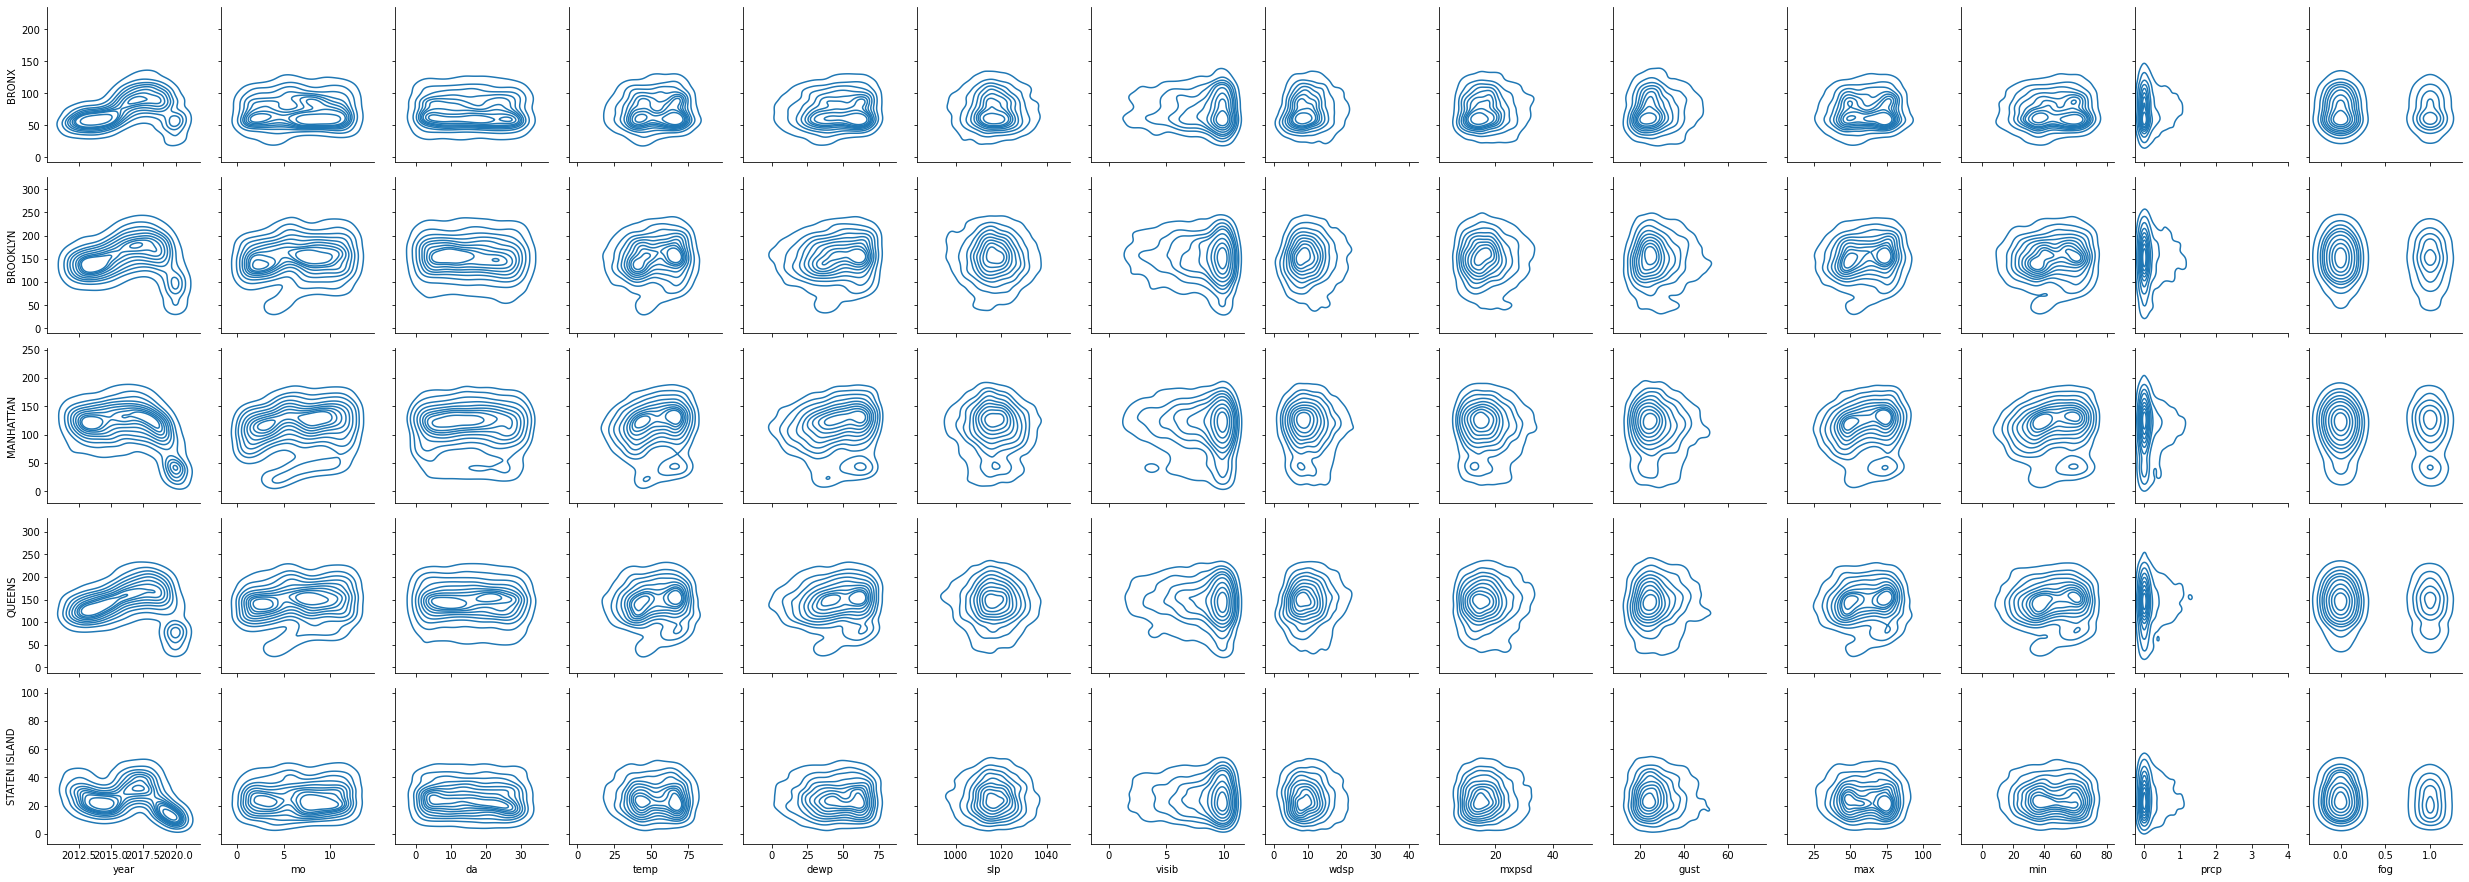

In [172]:
kde_plot = complete_df.drop('sndp', axis=1)
g= sns.PairGrid(kde_plot,
             x_vars = kde_plot.columns[:-5],
             y_vars = kde_plot.columns[-5:],
             )
g.map(sns.kdeplot)

Two new columns are made for the name of the day and the name of the month. These values are turned into 'dummies', where the data is transferred to the header and the column is marked with an entry of `1` or `0` depending on that `date`. This is called One Hot Encoding and prepares string variables for modeling.

In [191]:
complete_df.drop(['year', 'mo','da'], axis=1, inplace=True)
complete_df['day'] = complete_df.index.day_name()
complete_df['month'] = complete_df.index.month_name()
complete_df.head()

,temp,dewp,slp,visib,wdsp,mxpsd,gust,max,min,prcp,sndp,fog,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND,day,month
date,,,,,,,,,,,,,,,,,,,
2012-07-01,83.6,63.0,1008.9,9.7,4.1,9.9,18.1,93.0,66.0,0.00,NaN,0.0,43.0,140.0,122.0,117.0,31.0,Sunday,July
2012-07-02,80.3,54.1,1011.6,10.0,3.8,15.0,NaN,88.0,66.9,0.00,NaN,0.0,72.0,146.0,122.0,107.0,30.0,Monday,July
2012-07-03,79.8,56.7,1012.8,10.0,2.9,12.0,NaN,88.0,63.0,0.00,NaN,0.0,75.0,176.0,155.0,154.0,23.0,Tuesday,July
2012-07-04,81.8,65.6,1009.1,9.2,3.6,11.1,NaN,91.0,68.0,0.06,NaN,0.0,53.0,104.0,71.0,108.0,25.0,Wednesday,July
2012-07-05,86.7,64.3,1007.4,9.4,3.8,15.0,NaN,93.9,70.0,NaN,NaN,0.0,62.0,158.0,114.0,141.0,28.0,Thursday,July


In [199]:
OHE_month_day=pd.merge(pd.get_dummies(complete_df.month), pd.get_dummies(complete_df.day), left_index=True, right_index=True)
OHE_complete_df=pd.merge(complete_df.drop(['month','day'], axis=1), OHE_month_day, left_index=True, right_index=True)
OHE_complete_df

,temp,dewp,slp,visib,wdsp,mxpsd,gust,max,min,prcp,sndp,fog,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND,April,August,December,February,January,July,June,March,May,November,October,September,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-07-01,83.6,63.0,1008.9,9.7,4.1,9.9,18.1,93.0,66.0,0.00,NaN,0.0,43.0,140.0,122.0,117.0,31.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
2012-07-02,80.3,54.1,1011.6,10.0,3.8,15.0,NaN,88.0,66.9,0.00,NaN,0.0,72.0,146.0,122.0,107.0,30.0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
2012-07-03,79.8,56.7,1012.8,10.0,2.9,12.0,NaN,88.0,63.0,0.00,NaN,0.0,75.0,176.0,155.0,154.0,23.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2012-07-04,81.8,65.6,1009.1,9.2,3.6,11.1,NaN,91.0,68.0,0.06,NaN,0.0,53.0,104.0,71.0,108.0,25.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2012-07-05,86.7,64.3,1007.4,9.4,3.8,15.0,NaN,93.9,70.0,NaN,NaN,0.0,62.0,158.0,114.0,141.0,28.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-18,38.1,21.8,1022.4,10.0,15.4,21.0,28.0,54.0,33.1,0.00,NaN,0.0,57.0,90.0,37.0,70.0,6.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2020-11-19,37.2,24.1,1034.1,10.0,11.3,22.9,31.1,51.1,23.0,0.00,NaN,0.0,54.0,73.0,34.0,69.0,6.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2020-11-20,56.9,48.0,1027.4,9.0,19.8,26.0,32.1,62.1,52.0,0.00,NaN,0.0,46.0,107.0,45.0,88.0,10.0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0


Now the data is prepared, it is ready to be saved. 
Running the code below saves the data to the user's google drive under `My Drive`. The string saying `Dataset Successfully Saved!` will notify the user that a copy of the dataset has been saved to their google drive. 

In [200]:
save_collision_data = True
if save_collision_data == True:
  if drive:
    pass
  else:
    from google.colab import drive
    drive.mount('drive')

  OHE_complete_df.to_csv('Tom_Blackwood-Weather_and_Collision_data_for_New_York_boroughs_2012-2020.csv')
  !cp Tom_Blackwood-Weather_and_Collision_data_for_New_York_boroughs_2012-2020.csv "drive/My Drive"
  print("Dataset Successfully Saved!")

Dataset Successfully Saved!
